**Note**: Data training menggunakan data berikut: <br>
<a href="https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/data">https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/data</a>

# **IMPORT LIBRARIES**

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import confusion_matrix , accuracy_score , classification_report
from sklearn .ensemble import RandomForestClassifier 
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
import pickle 

**ydata-profiling** adalah library yang memungkinkan untuk menjalankan pemeriksaan kualitas data dan profiling dari DataFrame pandas maupun DataFrame Spark. Paket ini memungkinkan untuk menghasilkan laporan profiling data dengan cara yang sederhana dan cepat hanya melalui satu baris kode.

In [2]:
from ydata_profiling import ProfileReport

# **Eksplorasi Data Analisis (EDA)**

In [3]:
df = pd.read_csv("./data/healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

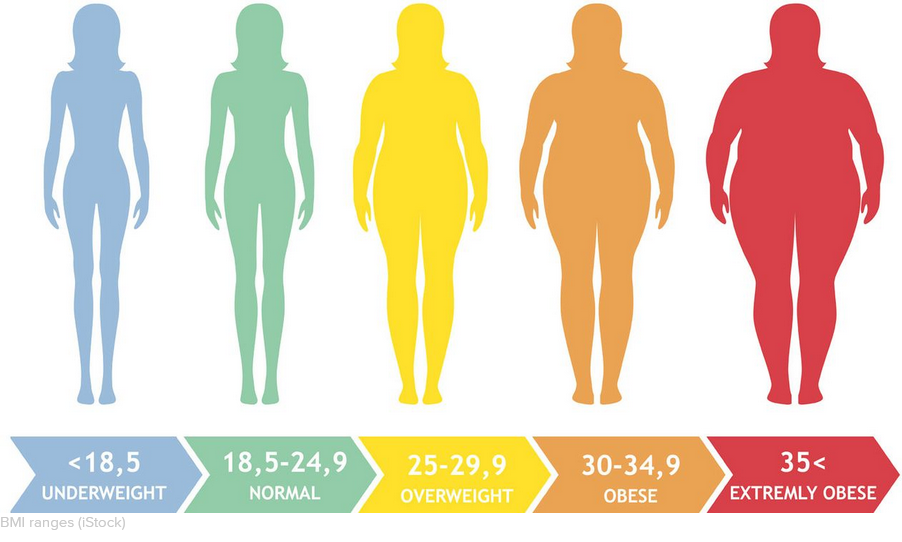

In [6]:
bmi_under_19=df[df['bmi']<=df['bmi'].median()]
bmi_over_35=df[df['bmi']>df['bmi'].median()]
print(bmi_under_19["stroke"].value_counts())
print("__________________")
print(bmi_over_35["stroke"].value_counts())

stroke
0    2398
1      85
Name: count, dtype: int64
__________________
stroke
0    2302
1     124
Name: count, dtype: int64


# **PREPROCESSING DATA**

## 1. Data Cleaning

In [7]:
# Menghapus kolom tidak penting (kolom id tidak diperlukan karena merupakan numerikal unik)
df.drop(['id'],axis=1,inplace = True)
# Menghapus baris yang duplikasi / sama
df.drop_duplicates(inplace=True)

In [8]:
# Mengecek outliers data pada gender, didapatkan ada gender 'Other' yang bisa process
df.loc[df["gender"]=="Other"]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


In [9]:
# Mengganti 'other' pada kolom 'gender' menjadi male karena tidak ada jenis kelamin 'other'
df["gender"].replace("Other","Male",inplace=True)

/tmp/ipykernel_4145686/390544299.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["gender"].replace("Other","Male",inplace=True)


/tmp/ipykernel_4145686/1464052313.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["stroke"],palette="dark:salmon_r")


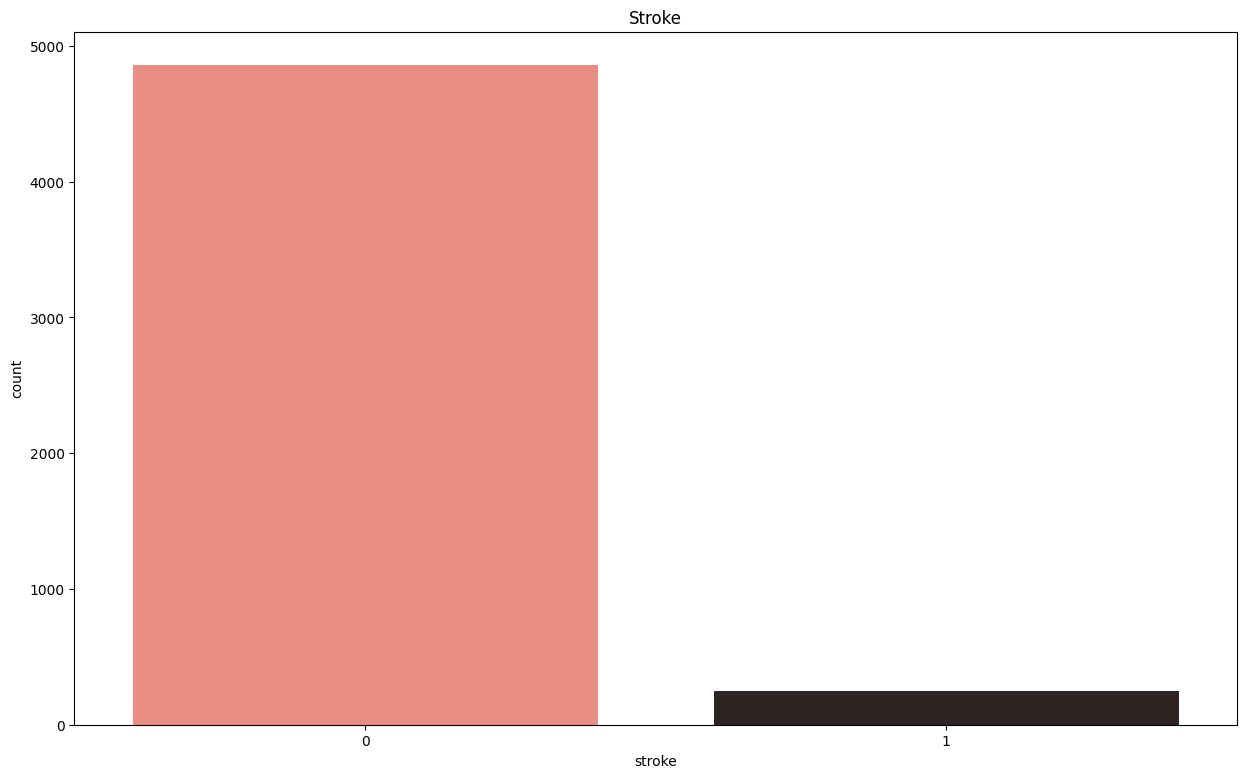

In [10]:
plt.figure(figsize=(15,9))
sns.countplot(x=df["stroke"],palette="dark:salmon_r")
plt.title("Stroke")
plt.show()

## 2. Balancing the Data (Resampling)

In [11]:
df['stroke'].value_counts()

stroke
0    4861
1     249
Name: count, dtype: int64

In [12]:
# Memisahkan data stroke nilai 0 dan 1
df_0 = df[df.iloc[:,-1]==0]
df_1 = df[df.iloc[:,-1]==1]

In [13]:
df_1 = resample(df_1,replace=True , n_samples=df_0.shape[0] , random_state=123 )

/tmp/ipykernel_4145686/1595880583.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["stroke"],palette="dark:salmon_r")


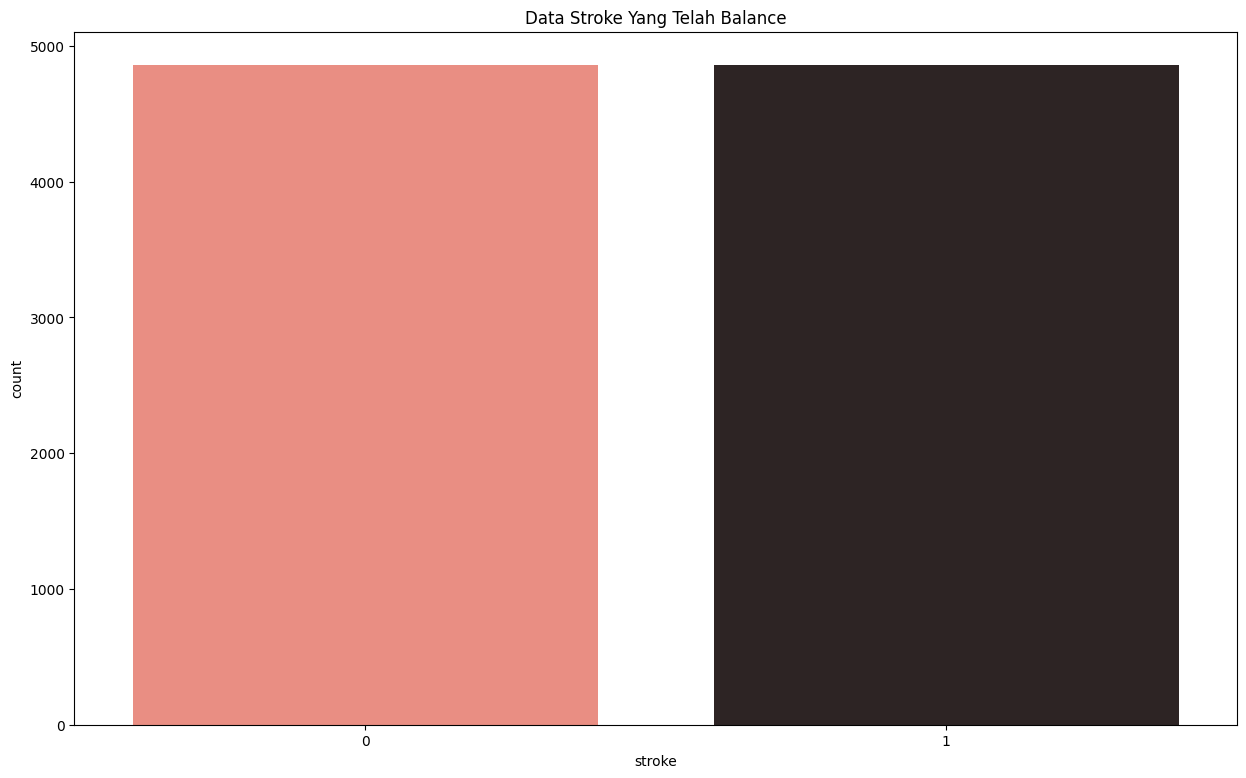

In [14]:
# Menggabungkan data
df = np.concatenate((df_0,df_1))

# Membuat data yang balance
df = pd.DataFrame(df)
df.columns = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married','work_type', 'Residence_type', 'avg_glucose_level', 'bmi','smoking_status', 'stroke']

# Visualisasi data yang telah balance
plt.figure(figsize=(15,9))
sns.countplot(x=df["stroke"],palette="dark:salmon_r")
plt.title("Data Stroke Yang Telah Balance")
plt.show()

## 3. Encoding Data

In [16]:
# Menentukan kolom yang perlu di-encode
columns_to_encode = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Melakukan encoding pada kolom kategori
label_encoders = {}
for column in columns_to_encode:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

with open('./model/label_encoders.pkl', 'wb') as encoders_file:
    pickle.dump(label_encoders, encoders_file)

In [17]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,3.0,0,0,0,4,0,95.12,18.0,0,0
1,1,58.0,1,0,1,2,1,87.96,39.2,2,0
2,0,8.0,0,0,0,2,1,110.89,17.6,0,0
3,0,70.0,0,0,1,2,0,69.04,35.9,1,0
4,1,14.0,0,0,0,1,0,161.28,19.1,0,0


In [18]:
# Mengecek apakah ada data Null
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  903
smoking_status         0
stroke                 0
dtype: int64

Imputasi KNN adalah teknik yang digunakan untuk mengisi nilai yang hilang dalam sebuah dataset dengan memanfaatkan algoritma K-Nearest Neighbors. Metode ini melibatkan pencarian k-neighbour terdekat dari sebuah titik data yang memiliki nilai yang hilang, kemudian mengisi nilai yang hilang tersebut menggunakan rata-rata atau median dari titik data neighbour tersebut. Pendekatan ini mempertahankan hubungan antar fitur, yang dapat menghasilkan kinerja model yang lebih baik dibandingkan dengan metode imputasi yang lebih sederhana, seperti imputasi rata-rata atau median.

In [19]:
# Menghandling Null Data dengan KNNImputer
imputer = KNNImputer(n_neighbors=5)  
df= imputer.fit_transform(df)

In [20]:
# Membuat dataframe baru setelah menghapus semua data null 
df=pd.DataFrame(df)
df.columns=[ 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married','work_type', 'Residence_type', 'avg_glucose_level', 'bmi','smoking_status', 'stroke']

In [21]:
df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [22]:
# Mengganti 0 (("Unknown") dalam data lama (sebelum encoding) menjadi nan
df['smoking_status']=df['smoking_status'].replace(0,np.nan)
# imputasi nilai nan dengan knn 
imputer=KNNImputer(n_neighbors=5)  
df=imputer.fit_transform(df)

In [23]:
# Membuat dataframe setelah mengganti 'Unkown' dalam data 'smoking status' dengan nilai nearest
df=pd.DataFrame(df)
df.columns=[ 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married','work_type', 'Residence_type', 'avg_glucose_level', 'bmi','smoking_status', 'stroke']
# Melakukan pembulana untuk data
df["smoking_status"]=df["smoking_status"].round()
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1.0,3.0,0.0,0.0,0.0,4.0,0.0,95.12,18.0,2.0,0.0
1,1.0,58.0,1.0,0.0,1.0,2.0,1.0,87.96,39.2,2.0,0.0
2,0.0,8.0,0.0,0.0,0.0,2.0,1.0,110.89,17.6,2.0,0.0
3,0.0,70.0,0.0,0.0,1.0,2.0,0.0,69.04,35.9,1.0,0.0
4,1.0,14.0,0.0,0.0,0.0,1.0,0.0,161.28,19.1,2.0,0.0


In [24]:
# Split Data Target Prediksi
x = df.drop('stroke', axis = 1)
y = pd.to_numeric( df['stroke'])

## 4. Scaling Data

In [25]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

with open('./model/scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

## **TRAINING MODEL**

In [26]:
# Split data train (80%) dan test (20%)
x_train , x_test , y_train , y_test = train_test_split(x,y,test_size = 0.20)

In [27]:
# Train Model menggunakan Random Forest
rf_model = RandomForestClassifier(n_estimators=150,criterion='entropy',random_state = 123)
rf_model.fit(x_train,y_train)

# Evaluasi model
train_predictions = rf_model.predict(x_train)
train_accuracy = accuracy_score(y_train, train_predictions)
print("Training Accuracy:", train_accuracy)
print("Classification Report (Training):\n", classification_report(y_train, train_predictions))

Training Accuracy: 1.0
Classification Report (Training):
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3926
         1.0       1.00      1.00      1.00      3851

    accuracy                           1.00      7777
   macro avg       1.00      1.00      1.00      7777
weighted avg       1.00      1.00      1.00      7777



In [28]:
# Evaluasi model menggunakan data testing
test_predictions = rf_model.predict(x_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print("Testing Accuracy:", test_accuracy)
print("Classification Report (Testing):\n", classification_report(y_test, test_predictions))

Testing Accuracy: 0.9938303341902314
Classification Report (Testing):
               precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       935
         1.0       0.99      1.00      0.99      1010

    accuracy                           0.99      1945
   macro avg       0.99      0.99      0.99      1945
weighted avg       0.99      0.99      0.99      1945



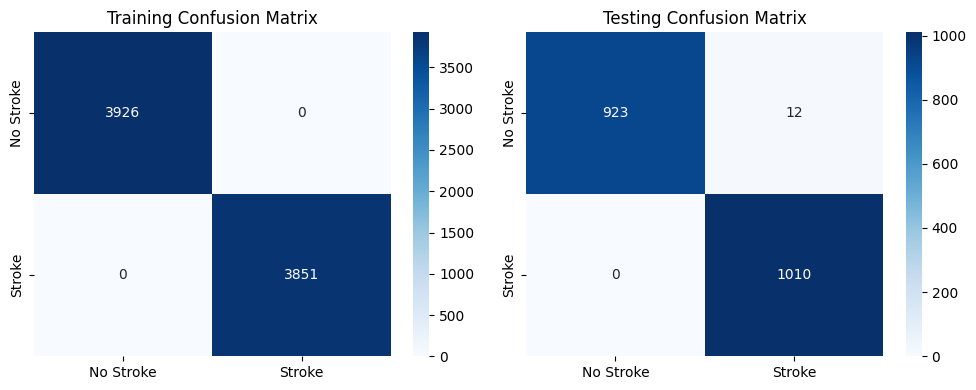

In [29]:
# Plot confusion matrix
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_train, train_predictions), 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'])
plt.title('Training Confusion Matrix')

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, test_predictions), 
            annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Stroke', 'Stroke'],
            yticklabels=['No Stroke', 'Stroke'])
plt.title('Testing Confusion Matrix')

plt.tight_layout()
plt.show()

# **SAVE MODEL**

In [30]:
with open('./model/stroke_prediction_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

print("Model disimpan pada './model/stroke_prediction_model.pkl'.")

Model disimpan pada './model/stroke_prediction_model.pkl'.


# **LOAD MODEL DAN TESTING PREDIKSI**

In [31]:
# Load model
with open('./model/stroke_prediction_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)
# Memuat label encoders
with open('./model/label_encoders.pkl', 'rb') as encoders_file:
    label_encoders = pickle.load(encoders_file)


print("Model berhasil di load.")

Model berhasil di load.


### **TESTING PREDIKSI DENGAN WEB-APP SEDERHANA YANG TELAH DIBUAT**